In [20]:
"""
@author: Yongji Wang
"""
import warnings
warnings.simplefilter("ignore")
import tensorflow as tf
from tensorflow.math import reduce_min, reduce_max
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from pyDOE import lhs
from scipy.io import savemat
from scipy.fft import fft, fftfreq, fftshift, fft2, fftn

In [2]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, t_u, x_u, layers, kappa, lt, ut, acts=0):

        self.scale = tf.reduce_max(tf.abs(x_u)) / 2
        x_u2 = x_u / self.scale
        actv = [tf.tanh, tf.sin]

        self.t_u = t_u
        self.x_u = x_u2
        self.datatype = t_u.dtype

        self.lt = lt
        self.ut = ut

        self.layers = layers
        self.kappa = kappa

        # determine the activation function to use
        self.actv = actv[acts]

        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)

        # Create a list including all training variables
        self.train_variables = self.weights + self.biases
        # Key point: anything updates in train_variables will be
        #            automatically updated in the original tf.Variable

        # define the loss function
        self.loss0 = self.scale ** 2
        self.loss = []
        self.loss_0 = self.loss_NN()

        self.optimizer_Adam = tf.optimizers.Adam()

    '''
    Functions used to establish the initial neural network
    ===============================================================
    '''

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)

        for l in range(0, num_layers - 1):
            W = self.MPL_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=self.datatype))
            weights.append(W)
            biases.append(b)
        return weights, biases

    def MPL_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=self.datatype))

    def get_params(self):
        return (self.weights, self.biases)

    '''
    Functions used to building the physics-informed contrainst and loss
    ===============================================================
    '''

    def neural_net(self, X):
        weights = self.weights
        biases = self.biases

        num_layers = len(weights) + 1

        H = 2.0 * tf.math.divide(
                    tf.math.subtract(X, tf.transpose(self.lt)), 
                    tf.transpose(tf.math.subtract(self.ut, self.lt))) \
            - 1.0

        W = weights[0]
        b = biases[0]
        H = self.actv(tf.add(self.kappa * tf.matmul(H, W), b))

        for l in range(1, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    @tf.function
    # calculate the physics-informed loss function
    def loss_NN(self):
        self.x_pred = self.neural_net(self.t_u)
        loss = tf.reduce_mean(tf.square(self.x_u - self.x_pred))
        return loss

    '''
    Functions used to define ADAM optimizers
    ===============================================================
    '''

    # define the function to apply the ADAM optimizer
    def adam_function(self):
        @tf.function
        def f():
            # calculate the loss
            loss_norm = self.loss_NN()
            loss_value = loss_norm * self.loss0
            # store loss value so we can retrieve later
            tf.py_function(f.loss.append, inp=[loss_value], Tout=[])

            # print out iteration & loss
            f.iter.assign_add(1)

            str_iter = tf.strings.as_string([f.iter])
            str_loss = tf.strings.as_string([loss_value], precision=4, scientific=True)

            str_print = tf.strings.join(["Mode: Adam", "Iter: ", str_iter[0],
                                         ", loss: ", str_loss[0]])
            tf.cond(
                f.iter % 10 == 0,
                lambda: tf.print(str_print),
                lambda: tf.constant(True)  # return arbitrary for non-printing case
            )
            return loss_norm

        f.iter = tf.Variable(0)
        f.term = []
        f.loss = []
        return f

    def Adam_optimizer(self, nIter):
        varlist = self.train_variables
        func_adam = self.adam_function()
        for it in range(nIter):
            tf.keras.optimizers.Adam(func_adam, varlist)
            #self.optimizer_Adam.minimize(func_adam, varlist)
        return func_adam

    '''
    Functions used to define L-BFGS optimizers
    ===============================================================
    '''

    # A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    def Lbfgs_function(self, varlist):
        # obtain the shapes of all trainable parameters in the model
        shapes = tf.shape_n(varlist)
        n_tensors = len(shapes)

        # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
        # prepare required information first
        count = 0
        idx = []  # stitch indices
        part = []  # partition indices

        for i, shape in enumerate(shapes):
            n = np.prod(shape)
            idx.append(tf.reshape(tf.range(count, count + n, dtype=tf.int32), shape))
            part.extend([i] * n)
            count += n

        part = tf.constant(part)

        def assign_new_model_parameters(params_1d):
            # A function updating the model's parameters with a 1D tf.Tensor.
            # Sub-function under function of class not need to input self

            params = tf.dynamic_partition(params_1d, part, n_tensors)
            for i, (shape, param) in enumerate(zip(shapes, params)):
                varlist[i].assign(tf.reshape(param, shape))

        @tf.function
        def f(params_1d):
            # A function that can be used by tfp.optimizer.lbfgs_minimize.
            # This function is created by function_factory.
            # Sub-function under function of class not need to input self

            # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
            with tf.GradientTape() as tape:
                # update the parameters in the model
                # this step is critical for self-defined function for L-BFGS
                assign_new_model_parameters(params_1d)
                # calculate the loss
                loss_norm = self.loss_NN()
                loss_value = loss_norm * self.loss0

            # calculate gradients and convert to 1D tf.Tensor
            grads = tape.gradient(loss_norm, varlist)
            grads = tf.dynamic_stitch(idx, grads)

            # store loss value so we can retrieve later
            tf.py_function(f.loss.append, inp=[loss_value], Tout=[])

            # print out iteration & loss
            f.iter.assign_add(1)

            str_iter = tf.strings.as_string([f.iter])
            str_loss = tf.strings.as_string([loss_value], precision=4, scientific=True)

            str_print = tf.strings.join(["Mode: LBFGS", "Iter: ", str_iter[0],
                                         ", loss: ", str_loss[0]])
            tf.cond(
                f.iter % 3000 == 0,
                lambda: tf.print(str_print),
                lambda: tf.constant(True)  # return arbitrary for non-printing case
            )

            return loss_value, grads

        # store these information as members so we can use them outside the scope
        f.iter = tf.Variable(0)
        f.idx = idx
        f.part = part
        f.shapes = shapes
        f.assign_new_model_parameters = assign_new_model_parameters
        f.loss = []

        return f

    # define the function to apply the L-BFGS optimizer
    def Lbfgs_optimizer(self, nIter, varlist):

        func = self.Lbfgs_function(varlist)

        # convert initial model parameters to a 1D tf.Tensor
        init_params = tf.dynamic_stitch(func.idx, varlist)

        max_nIter = tf.cast(nIter / 3, dtype=tf.int32)

        # train the model with L-BFGS solver
        results = tfp.optimizer.lbfgs_minimize(
            value_and_gradients_function=func, initial_position=init_params,
            tolerance=1e-11, max_iterations=max_nIter)

        # after training, the final optimized parameters are still in results.position
        # so we have to manually put them back to the model
        func.assign_new_model_parameters(results.position)

        return func

    '''
    Function used for training the model
    ===============================================================
    '''

    def train(self, nIter, idxOpt):
        if idxOpt == 1:
            # mode 1: running the Adam optimization
            func_adam = self.Adam_optimizer(nIter)
            self.loss += func_adam.loss
        elif idxOpt == 2:
            # mode 2: running the Lbfgs optimization
            func_bfgs = self.Lbfgs_optimizer(nIter, self.train_variables)
            self.loss += func_bfgs.loss

    # @tf.function
    def predict(self, t):
        x_p = self.neural_net(t) * self.scale
        return x_p

    


In [25]:
np.random.seed(234)
tf.random.set_seed(234)

def fun_test(t):
    # customize the function by the user
    x = (t ** 3) / (0.01 + t ** 4) # example 2
    #x = tf.math.log(t+2) * tf.cos(2*t + t**3)   # example 1
    # x = tf.sin(2*t+1) + 0.2*tf.exp(1.3*t)  # example 2
    return x

def create_ds(dims, lo, hi, N):
    dimensions = [np.linspace(lo, hi, N)] * dims
    mesh = np.meshgrid(*dimensions, indexing='xy')
    mesh_points = np.stack([m.flatten() for m in mesh], axis=-1)
    mesh_tf = tf.cast(mesh_points, dtype=tf.float64)
    return mesh_tf

def fun_test2d(t):
    x = (np.sin(2 * t[:, 0] + 1) - 0.5 * t[:, 0])*(1 - t[:, 1] ** 2)
    return x

N_train = 21
t_train = create_ds(2, -1.02, 1.02, N_train)
x_train = tf.reshape(fun_test2d(t_train), [len(t_train), 1])
print(t_train.shape)
print(x_train.shape)

# Domain bounds
lt = [reduce_min(t_train[:, 0]), reduce_min(t_train[:, 1])]
ut = [reduce_max(t_train[:, 0]), reduce_max(t_train[:, 1])]
lt = tf.convert_to_tensor(lt)
ut = tf.convert_to_tensor(ut)

# Number of test points (total # = N_eval ** 2)
N_eval = 200
t_eval = create_ds(2, -1.02, 1.02, N_eval)
x_eval = tf.reshape(fun_test2d(t_eval), [len(t_eval), 1])
print(t_eval.shape)
print(x_eval.shape)

(441, 2)
(441, 1)
(40000, 2)
(40000, 1)


In [31]:
'''
First stage of training
'''
# acts = 0 indicates selecting tanh as the activation function
layers = [2, 20, 20, 20, 1]
kappa = 1
model = PhysicsInformedNN(t_train, x_train, layers, kappa, lt, ut, acts=0)
# start the first stage training
model.train(3000, 1)     # mode 1 use Adam
model.train(10000, 2)    # mode 2 use L-bfgs
x_pred = model.predict(t_eval)
#####################################################################

Mode: LBFGSIter: 3000, loss: 8.6070e-07
Mode: LBFGSIter: 6000, loss: 2.6280e-07
Mode: LBFGSIter: 9000, loss: 1.0748e-07


In [32]:
'''
Second stage of training
'''
# calculate the residue for the second stage
x_train2 = x_train - model.predict(t_train)

###############################################
# Calculate dominant frequency
g = x_train2.numpy().flatten()
GG = g.reshape(N_train, N_train)
G = fft2(GG)
G_shifted = fftshift(G)

N = len(G)
# Total time range
total_time_range = 2  # from -1 to 1

# Calculate the sample rate
sample_rate = N / total_time_range

# Perform FFT
half_N = N // 2
T = 1.0 / sample_rate
G_pos = G_shifted[half_N:, half_N:]
freq_x = fftshift(fftfreq(GG.shape[1], d=T))
freq_y = fftshift(fftfreq(GG.shape[0], d=T))

freq_x_pos = freq_x[half_N:]
freq_y_pos = freq_y[half_N:]

# Identify the dominant frequency
magnitude_spectrum = np.abs(G_pos)
max_idx = np.unravel_index(np.argmax(magnitude_spectrum), magnitude_spectrum.shape)
dominant_freq_x = freq_x_pos[max_idx[1]]
dominant_freq_y = freq_y_pos[max_idx[0]]
magnitude = magnitude_spectrum[max_idx] / (N * N) # normalize magnitude
dominant_freq = max(dominant_freq_x, dominant_freq_y)

print(f"Sample Rate: {sample_rate} Hz")
print(f"Dominant Frequency: {dominant_freq} Hz")
print(f"Magnitude: {magnitude}")
kappa2f =  2 * np.pi * dominant_freq
print(f"kappa2f: {kappa2f}")
######################################################

# get the scale factor approximately by finding the number of zeros of the residues)
# (more official way is to use the fourier transform and get dominant frequency)
idxZero = np.where(x_train2[0:-1, 0] * x_train2[1:, 0] < 0)[0]
NumZero = idxZero.shape[0]
kappa2 = 3*NumZero
print(f"kappa2: {kappa2}")

Sample Rate: 10.5 Hz
Sample Rate: 10.5 Hz
Dominant Frequency: 1.0 Hz
Magnitude: 6.545446512673152e-05
kappa2f: 6.283185307179586
kappa2: 414


In [36]:
# Increase data from 21 -> 61 points
N_train = 61
t1 = np.linspace(-1.02, 1.02, N_train)[:, None]
t2 = np.linspace(-1.02, 1.02, N_train)[:, None]
xx, yy = np.meshgrid(t1, t2)
t = tf.stack([tf.reshape(xx, [-1]), tf.reshape(yy, [-1])], axis=1)
t_train2 = tf.cast(t, dtype=tf.float64)
x_train = tf.reshape(fun_test2d(t_train2), [len(t), 1])
x_train2 = x_train - model.predict(t_train2)

# Domain bounds
lt = [t1.min(0)[0], t2.min(0)[0]]
ut = [t1.max(0)[0], t2.max(0)[0]]
lt = tf.convert_to_tensor(lt)
ut = tf.convert_to_tensor(ut)

In [37]:
# (acts = 1 indicates selecting sin as the activation function)
model2 = PhysicsInformedNN(t_train2, x_train2, layers, kappa2f, lt, ut, acts=1)
# start the second stage training
model2.train(5000, 1)    # mode 1 use Adam
model2.train(20000, 2)   # mode 2 use L-bfgs
x_pred2 = model2.predict(t_eval)
# combining the result from first and second stage
x_p = x_pred + x_pred2

Mode: LBFGSIter: 3000, loss: 1.1742e-10
Mode: LBFGSIter: 6000, loss: 5.2201e-11
Mode: LBFGSIter: 9000, loss: 2.9069e-11
Mode: LBFGSIter: 12000, loss: 1.9028e-11
Mode: LBFGSIter: 15000, loss: 1.3525e-11
Mode: LBFGSIter: 18000, loss: 1.0473e-11


In [38]:
'''
Third stage of training
'''

# calculate the residue for the third stage
x_train3 = x_train - model.predict(t_train2) - model2.predict(t_train2)


###############################################
# Calculate dominant frequency
g = x_train3.numpy().flatten()
GG = g.reshape(N_train, N_train)
G = fft2(GG)
G_shifted = fftshift(G)

N = len(G)
# Total time range
total_time_range = 2  # from -1 to 1

# Calculate the sample rate
sample_rate = N / total_time_range

# Perform FFT
half_N = N // 2
T = 1.0 / sample_rate
G_pos = G_shifted[half_N:, half_N:]
freq_x = fftshift(fftfreq(GG.shape[1], d=T))
freq_y = fftshift(fftfreq(GG.shape[0], d=T))

freq_x_pos = freq_x[half_N:]
freq_y_pos = freq_y[half_N:]

# Identify the dominant frequency
magnitude_spectrum = np.abs(G_pos)
max_idx = np.unravel_index(np.argmax(magnitude_spectrum), magnitude_spectrum.shape)
dominant_freq_x = freq_x_pos[max_idx[1]]
dominant_freq_y = freq_y_pos[max_idx[0]]
magnitude = magnitude_spectrum[max_idx] / (N * N) # normalize magnitude
dominant_freq = max(dominant_freq_x, dominant_freq_y)

print(f"Sample Rate: {sample_rate} Hz")
print(f"Dominant Frequency: {dominant_freq} Hz")
print(f"Magnitude: {magnitude}")
kappa3f =  2 * np.pi * dominant_freq
print(f"kappa3f: {kappa3f}")
######################################################

# get the scale factor approximately by finding the number of zeros of the residues)
idxZero = np.where(x_train3[0:-1, 0] * x_train3[1:, 0] < 0)[0]
NumZero2 = idxZero.shape[0]
kappa3 = 3*NumZero2
print(f"kappa3: {kappa3}")

Sample Rate: 30.5 Hz
Dominant Frequency: 4.5 Hz
Magnitude: 2.908547487624634e-07
kappa3f: 28.274333882308138
kappa3: 3024


In [42]:
# increase the data points from 61 -> 121
N_train = 121
t1 = np.linspace(-1.02, 1.02, N_train)[:, None]
t2 = np.linspace(-1.02, 1.02, N_train)[:, None]
xx, yy = np.meshgrid(t1, t2)
t = tf.stack([tf.reshape(xx, [-1]), tf.reshape(yy, [-1])], axis=1)
t_train3 = tf.cast(t, dtype=tf.float64)
x_train = tf.reshape(fun_test2d(t_train3), [len(t), 1])
x_train3 = x_train - model.predict(t_train3) - model2.predict(t_train3)

# Domain bounds
lt = [t1.min(0)[0], t2.min(0)[0]]
ut = [t1.max(0)[0], t2.max(0)[0]]
lt = tf.convert_to_tensor(lt)
ut = tf.convert_to_tensor(ut)

In [40]:
# (acts = 1 indicates selecting sin as the activation function)
layers2 = [2, 30, 30, 30, 1]
model3 = PhysicsInformedNN(t_train, x_train3, layers2, kappa3f, lt, ut, acts=1)
# start the third stage training
model3.train(5000, 1)      # mode 1 use Adam
model3.train(30000, 2)     # mode 2 use L-bfgs
x_pred3 = model3.predict(t_eval)
# combining the result from first, second and third stages
x_p2 = x_pred + x_pred2 + x_pred3

Mode: LBFGSIter: 3000, loss: 1.0451e-12
Mode: LBFGSIter: 6000, loss: 5.3529e-13
Mode: LBFGSIter: 9000, loss: 3.5795e-13
Mode: LBFGSIter: 12000, loss: 2.6487e-13
Mode: LBFGSIter: 15000, loss: 2.1857e-13
Mode: LBFGSIter: 18000, loss: 1.8124e-13
Mode: LBFGSIter: 21000, loss: 1.4826e-13
Mode: LBFGSIter: 24000, loss: 1.2403e-13
Mode: LBFGSIter: 27000, loss: 9.8575e-14


In [52]:
'''
Fourth stage of training
'''
# calculate the residue for the forth stage
x_train4 = x_train - model.predict(t_train3) - model2.predict(t_train3) - model3.predict(t_train3)

###############################################
# Calculate dominant frequency
g = x_train4.numpy().flatten()
GG = g.reshape(N_train, N_train)
G = fft2(GG)
G_shifted = fftshift(G)

N = len(G)
# Total time range
total_time_range = 2  # from -1 to 1

# Calculate the sample rate
sample_rate = N / total_time_range

# Perform FFT
half_N = N // 2
T = 1.0 / sample_rate
G_pos = G_shifted[half_N:, half_N:]
freq_x = fftshift(fftfreq(GG.shape[1], d=T))
freq_y = fftshift(fftfreq(GG.shape[0], d=T))

freq_x_pos = freq_x[half_N:]
freq_y_pos = freq_y[half_N:]

# Identify the dominant frequency
magnitude_spectrum = np.abs(G_pos)
max_idx = np.unravel_index(np.argmax(magnitude_spectrum), magnitude_spectrum.shape)
dominant_freq_x = freq_x_pos[max_idx[1]]
dominant_freq_y = freq_y_pos[max_idx[0]]
magnitude = magnitude_spectrum[max_idx] / (N * N) # normalize magnitude
dominant_freq = max(dominant_freq_x, dominant_freq_y)

print(f"Sample Rate: {sample_rate} Hz")
print(f"Dominant Frequency: {dominant_freq} Hz")
print(f"Magnitude: {magnitude}")
kappa4f =  2 * np.pi * dominant_freq
print(f"kappa4f: {kappa4f}")
######################################################


# get the scale factor approximately by finding the number of zeros of the residues)
idxZero = np.where(x_train4[0:-1, 0] * x_train4[1:, 0] < 0)[0]
NumZero3 = idxZero.shape[0]
kappa4 = 3*NumZero3
print(f"kappa4: {kappa4}")

Sample Rate: 60.5 Hz
Dominant Frequency: 7.0 Hz
Magnitude: 1.3306890773200296e-08
kappa4f: 43.982297150257104
kappa4: 10242


In [53]:
# (acts = 1 indicates selecting sin as the activation function)
model4 = PhysicsInformedNN(t_train, x_train4, layers2, kappa4f, lt, ut)
# start the forth stage training
model4.train(5000, 1)
model4.train(40000, 2)
x_pred4 = model4.predict(t_eval)
# combining the result from all stages
x_p3 = x_pred + x_pred2 + x_pred3 + x_pred4

Mode: LBFGSIter: 3000, loss: 8.2730e-14
Mode: LBFGSIter: 6000, loss: 8.1677e-14
Mode: LBFGSIter: 9000, loss: 8.1098e-14
Mode: LBFGSIter: 12000, loss: 8.0407e-14
Mode: LBFGSIter: 15000, loss: 8.0192e-14
Mode: LBFGSIter: 18000, loss: 7.9867e-14
Mode: LBFGSIter: 21000, loss: 7.9714e-14
Mode: LBFGSIter: 24000, loss: 7.9604e-14
Mode: LBFGSIter: 27000, loss: 7.9563e-14
Mode: LBFGSIter: 30000, loss: 7.9560e-14
Mode: LBFGSIter: 33000, loss: 7.9350e-14
Mode: LBFGSIter: 36000, loss: 7.9174e-14
Mode: LBFGSIter: 39000, loss: 7.9016e-14


In [54]:
#%%
# combine the loss of all four stages of training
loss = np.array(model.loss + model2.loss + model3.loss + model4.loss)

residue = x_train4 - model4.predict(t_train)

error_x = np.linalg.norm(x_eval-x_pred, 2)/np.linalg.norm(x_eval, 2)
print('Error u: %e' % (error_x))

error_x2 = np.linalg.norm(x_eval-x_p, 2)/np.linalg.norm(x_eval, 2)
print('Error u: %e' % (error_x2))

error_x3 = np.linalg.norm(x_eval-x_p2, 2)/np.linalg.norm(x_eval, 2)
print('Error u: %e' % (error_x3))

error_x4 = np.linalg.norm(x_eval-x_p3, 2)/np.linalg.norm(x_eval, 2)
print('Error u: %e' % (error_x4))

mdic = {"t": t_eval.numpy(), "x_g": x_eval.numpy(), "x0": x_pred.numpy(),
        "x1": x_pred2.numpy(), "x2": x_pred3.numpy(), 'x3': x_pred4.numpy(),
        "err": residue.numpy(), 'loss': loss}
FileName = 'Reg_mNN_1D_64bit.mat'
savemat(FileName, mdic)

#%%

Error u: 7.185221e-04
Error u: 7.520850e-06
Error u: 7.586698e-07
Error u: 7.310768e-07


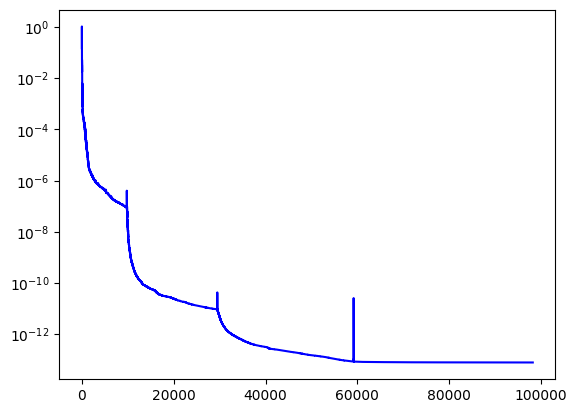

In [55]:
plt.figure()
plt.plot(loss, 'b-')
plt.yscale("log")